# NLP 2021 Homework 3: Word Sense Disambiguation of Word-in-Context data
### Leandro Maglianella - 1792507

## Preliminaries

### Libraries Import and Setup

In [1]:
# Import Google Drive and acquire data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Suppress output, will only show errors if they occur
%%capture
# Install libraries that are not already included in Colab
! pip install transformers
! pip install pytorch-lightning
! pip install jsonlines

In [3]:
# Import libraries
import os
import numpy as np
from typing import Optional, List, Dict, Union, Tuple
import jsonlines
import xml.etree.ElementTree as ET
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import pytorch_lightning as pl
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AdamW
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print('\nLibraries imported!')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.

Libraries imported!


### Experimental Parameters Setting

Set the desired configuration for the experiment:

In [4]:
# Seed set (to my matricola) to ensure the repeatability of my work
pl.seed_everything(1792507)
torch.backends.cudnn.deterministic = True

# Check if the working environment can use a GPU for PyTorch
if torch.cuda.is_available():
  device = torch.device('cuda')
  gpu = 1
else:
  device = torch.device('cpu')
  gpu = 0
print('PyTorch device: ', device)

# Datasets
train_dataset = 'SemCor_small'
val_dataset = 'ALL'
test_dataset = 'wic_data'

# The original SemCor dataset has 352 texts, being it to big to be processed here in Colab (RAM limits)..
# ..I created two reduced versions of it: SemCor (118 texts) and SemCor_small (24 texts)
assert train_dataset in ['SemCor', 'SemCor_small']
assert val_dataset in ['semeval2007', 'semeval2013', 'semeval2015', 'senseval2', 'senseval3', 'ALL']
assert test_dataset in ['wic_data'] # if needed ['wic_data', 'semeval2007', 'semeval2013', 'semeval2015', 'senseval2', 'senseval3', 'ALL']

# ------------------ Set paths ------------------
# 2 data folders:
#      - wic_data: data from https://github.com/SapienzaNLP/nlp2021-hw3 repo
#      - wsd_data: Evaluation_Datasets and Training_Corpora from http://lcl.uniroma1.it/wsdeval/
base_data_path = '/content/drive/MyDrive/Colab Notebooks/NLP/hw3/data/'
base_models_path = '/content/drive/MyDrive/Colab Notebooks/NLP/hw3/models/'
train_data_path = base_data_path + 'wsd_data/Training_Corpora/' + train_dataset + '/' + train_dataset.lower() + '.data.xml'
train_key_path = base_data_path + 'wsd_data/Training_Corpora/' + train_dataset + '/' + train_dataset.lower() + '.gold.key.txt'
val_data_path = base_data_path + 'wsd_data/Evaluation_Datasets/' + val_dataset + '/' + val_dataset + '.data.xml'
val_key_path = base_data_path + 'wsd_data/Evaluation_Datasets/' + val_dataset + '/' + val_dataset + '.gold.key.txt'
test_data_path = base_data_path + 'wic_data/dev.jsonl'
test_key_path = base_data_path + 'wic_data/dev_wsd.txt'

# ------------------ Training parameters ------------------
# pretrained BERT model from which I start
pretrained_bert =  'bert-base-uncased'
assert pretrained_bert in ['bert-base-uncased', 'bert-large-uncased', 'bert-large-uncased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad']

batch_size = 8
epochs = 1
val_interval = 0.1 # 10 validations during 1 epoch, done to plot the training process
learning_rate = 2e-5
epsilon = 1e-8
hidden_size = 768 if pretrained_bert == 'bert-base-uncased' else 1024
dropout = 0.1

show_examples = True # To run some example cells about how my code works
log_stuff = True # To log loss and accuracy during the training phase, useful just to later plot in Tensorboard

# POS tags mapping: in wordnet verb->v, noun->n, adj->a, adv->r
pos_map = {'VERB': 'v', 'NOUN': 'n', 'ADJ': 'a', 'ADV': 'r'}

# Initializing a BertTokenizer, used both for preprocessing and for the model
tokenizer = BertTokenizer.from_pretrained(pretrained_bert, do_lower_case=True)
# Using second pre-processing approach
tokenizer.add_special_tokens({'additional_special_tokens': ['[TRG]']})

print('\nParameters set!')

Global seed set to 1792507


PyTorch device:  cuda


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]


Parameters set!


## Data Pre-processing

### Pre-processing Functions

Functions to go from data to samples stored in *Drive*.

The preprocess_dataset function (later used inside the generate_samples function) extracts useful info from the WSD datasets or WIC dataset:
  - Each WSD dataset has: a .xml file (data) and a txt file (keys)
  - The WIC dataset has: two .jsonl files (train and dev) and a txt file (dev_wsd), I will use only the dev files.

In [5]:
'''
Extract useful info from the WSD datasets or WIC dataset:
  - Each WSD dataset has: a .xml file (data) and a txt file (keys)
  - The WIC dataset has: two .jsonl files (train and dev) and a txt file (dev_wsd), I will use only the dev files
This function is used inside the generate_samples function
'''
def preprocess_datasets(data_path, key_path, wic = False):
  sentences = [] 
  tags = []
  lemmas = []
  instances = []
  keys = []
  # --------------------------------- WSD dataset processing -----------------------------
  if wic==False:
    # xml file processing
    with open(data_path, 'rb') as xml_file:
      xml_tree = ET.parse(xml_file)
      root = xml_tree.getroot()
      for text in root:
        for sentence in text:
          _sentence = ''
          pos = []
          lemma = []
          instance = []
          for word in sentence:
            _sentence += word.text + ' '
            # word.tag for simple words is 'wf', 'instance' for ambiguous words
            # Store info only of ambiguous words
            if word.tag == 'instance':
              pos.append(word.attrib['pos'])
              lemma.append(word.attrib['lemma'])
              instance.append(word.text)
          tags.append(pos)
          lemmas.append(lemma)
          sentences.append(_sentence)
          instances.append(instance)
    # Keys extraction from the txt file
    with open(key_path) as f:
      txt_lines = f.readlines()
      i = 0
      for sentence_instances in instances:
        sentence_keys = []
        for instance in sentence_instances:
          sentence_keys.append(txt_lines[i].split()[1]) # [0] is the id, [1] the key
          i += 1
        keys.append(sentence_keys)
  # ------------------------------ WIC dataset processing -------------------------------
  elif wic==True:
    # jsonl file processing
    with jsonlines.open(data_path) as f:
      for line in f.iter():
        sentences.append(line['sentence1'])
        tags.append([line['pos']])
        lemmas.append([line['lemma']])
        instances.append([line['sentence1'][int(line['start1']):int(line['end1'])]])

        sentences.append(line['sentence2'])
        tags.append([line['pos']])
        lemmas.append([line['lemma']])
        instances.append([line['sentence2'][int(line['start2']):int(line['end2'])]])
    # Keys extraction from the txt file
    with open(key_path) as f:
      lines = f.readlines()
      for line in lines:
        keys.append([line.split()[1]])
  
  return sentences, tags, lemmas, instances, keys

Given the outputs of preprocess_datasets, a list of samples following BERT standards for the model is created using the generate_samples function. In particular, the GlossBERT method is used.

Each sample is composed of some items; each item containing four tensors:
  - ids: indexes of [[CLS], ..sentence_tokens.., [SEP], ..gloss_tokens.., [SEP]] where sentence_tokens is ..., [TRG], [instance], [TRG], ...
  - attention_masks: [1, 1, ..., 1] of the same len as ids
  - ids_categories:  [0, 0, ..., 1, ..] of the same len as ids; zeros up to (and including) the first [SEP], then ones
  - label: [1] if this item includes the right gloss, [0] for all the other items of the sample

In [6]:
'''
Given the outputs of preprocess_datasets, a list of samples following BERT standards for the model is created. In particular, the GlossBERT method is used.
Each sample is composed of some items; each item containing four tensors:
  - ids: indexes of [[CLS], ..sentence_tokens.., [SEP], ..gloss_tokens.., [SEP]] where sentence_tokens is ..., [TRG], [instance], [TRG], ...
  - attention_masks: [1, 1, ..., 1] of the same len as ids
  - ids_categories:  [0, 0, ..., 1, ..] of the same len as ids; zeros up to (and including) the first [SEP], then ones
  - label: [1] if this item includes the right gloss, [0] for all the other items of the sample
'''
def generate_samples(data_path: str, key_path: str, wic: bool = False):
  sentences, tags, lemmas, instances, keys = preprocess_datasets(data_path, key_path, wic)
  samples = []
  for i in range(len(sentences)):
    for j in range(len(instances[i])):
      sample = []
      glosses_and_labels = []
      ambiguous_word = lemmas[i][j]
      pos = pos_map[tags[i][j]] 
      # I will need two elements for the GlossBERT processing: the sentence and the possible glosses for the ambiguous word
      # -------------- 1: Form (gloss, 0||1) couples ------------------
      for synset in (wn.synsets(ambiguous_word, pos)):
        # Establish which key is the right one for this synset
        for lemma in synset.lemmas():
          if lemma.name().lower() == ambiguous_word.lower():
            key = lemma.key()
            break
          elif lemma.name().lower() in wn._morphy(ambiguous_word, pos):
            key = lemma.key()
          else:
            key = ''
        # Here the couples are formed: (gloss, 1) for the right gloss, else (gloss, 0)
        if key == keys[i][j]:
          glosses_and_labels.append((synset.definition(), 1))
        else:
          glosses_and_labels.append((synset.definition(), 0))
      # ------------------ 2: Sentence ------------------
      # Find the index of the ambiguous word instance, add [TRG] tokens near it
      instance_position = sentences[i].find(instances[i][j])
      if instance_position >= 0:
        preproc_sentence = sentences[i][0:instance_position] + '[TRG] ' + instances[i][j] + ' [TRG]' + sentences[i][instance_position+len(instances[i][j]):]
      else:
        preproc_sentence = sentences[i] # just in case, but this should never happen
      # -------------- 3: Here the two elements are merged together to form the sample --------------
      sentence_tokens = tokenizer.tokenize(preproc_sentence)
      for gloss, label in glosses_and_labels:
        gloss_tokens = tokenizer.tokenize(gloss)
        ids_categories = [0] * (len(sentence_tokens) + 2) + [1] * (len(gloss_tokens) + 1)
        # From tokens to indexes
        tokens = ['[CLS]'] + sentence_tokens + ['[SEP]'] + gloss_tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        attention_masks = [1] * len(ids)
        sample.append([ids, attention_masks, ids_categories, label])
      samples.append(sample)
  return samples

### Pre-processing Examples

In [7]:
# Example of ids difference using Approach 1 or 2 for pre-processing
if show_examples:
  # The definition is the same for both approaches
  gloss = 'any of numerous small rodent'
  gloss_tokens = tokenizer.tokenize(gloss)

  print('APPROACH 1')
  sentence = 'The cat eats the mouse'
  sentence_tokens = tokenizer.tokenize(sentence)
  tokens = ['[CLS]'] + sentence_tokens + ['[SEP]'] + gloss_tokens + ['[SEP]']
  ids = tokenizer.convert_tokens_to_ids(tokens)
  print(tokens) # Notice the WordPiece embedding in 'rodent'
  print(ids)

  print('\nAPPROACH 2')
  preproc_sentence = 'The cat eats the [TRG] mouse [TRG]'
  preproc_sentence_tokens = tokenizer.tokenize(preproc_sentence)
  preproc_tokens = ['[CLS]'] + preproc_sentence_tokens + ['[SEP]'] + gloss_tokens + ['[SEP]'] + ['[PAD]'] # PAD are later added in the collate function
  preproc_ids = tokenizer.convert_tokens_to_ids(preproc_tokens)
  print(preproc_tokens)
  print(preproc_ids)

APPROACH 1
['[CLS]', 'the', 'cat', 'eats', 'the', 'mouse', '[SEP]', 'any', 'of', 'numerous', 'small', 'rode', '##nt', '[SEP]']
[101, 1996, 4937, 20323, 1996, 8000, 102, 2151, 1997, 3365, 2235, 8469, 3372, 102]

APPROACH 2
['[CLS]', 'the', 'cat', 'eats', 'the', '[TRG]', 'mouse', '[TRG]', '[SEP]', 'any', 'of', 'numerous', 'small', 'rode', '##nt', '[SEP]', '[PAD]']
[101, 1996, 4937, 20323, 1996, 30522, 8000, 30522, 102, 2151, 1997, 3365, 2235, 8469, 3372, 102, 0]


In [8]:
if show_examples:
  # Example using test data
  data_samples = generate_samples(test_data_path, test_key_path, wic=True)
  # print the first item of the first sample
  print(data_samples[0][0])

[[101, 2053, 11075, 1999, 1037, 3206, 4618, 2022, 10009, 2004, 9345, 4667, 1996, 5368, 1997, 30522, 22983, 30522, 2104, 2248, 2375, 1012, 102, 2028, 1997, 3618, 4635, 2030, 2276, 2030, 3737, 102], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1]


### Storing of Pre-processed Data

As shown in the previous example, using generate_samples I can generate samples on the spot and use them.

Anyway, to speed up and lighten future executions I am going to store the results of the pre-processing in my ***Google Drive***: to do so I will use ***Pickle***, an easy serialization library.

Also some data used later in the Final Testing section is here stored.

In [9]:
# -------------------------- Datasets to Pickle ---------------------------------
for i, dataset in enumerate([train_dataset, val_dataset, test_dataset]):
  if os.path.isfile(base_data_path + dataset.lower() + '.pkl'):
    print(dataset, 'already stored on Drive: I will use it.\n')
  else:
    print(dataset, 'is not in Drive: I will save it and then use it.')
    print('Generating samples...')
    if i == 0:
      data_samples = generate_samples(train_data_path, train_key_path, wic=False)
    elif i == 1:
      data_samples = generate_samples(val_data_path, val_key_path, wic=False)
    elif i == 2:
      data_samples = generate_samples(test_data_path, test_key_path, wic=True if dataset=='wic_data' else False)
    print('Saving samples...\n')
    with open(base_data_path + dataset.lower() + '.pkl', 'wb') as f:
        pickle.dump(data_samples, f)

# ---------- Data and keys (for Final Testing) to Pickle ------------
# Similar to preprocess_datasets wic = True
if os.path.isfile(base_data_path + 'final_wic_gold.pkl'):
  print('Final data already stored on Drive: I will later use it in Final Testing.')
else:
  wic_gold = []
  wsd_gold = []
  wic_data = []

  with jsonlines.open(test_data_path) as f:
    for line in f.iter():
      wic_data.append(line)
      wic_gold.append(line['label'])
  with open(base_data_path + 'final_wic_gold.pkl', 'wb') as f:
    pickle.dump(wic_gold, f)
  with open(base_data_path + 'final_wic_data.pkl', 'wb') as f:
    pickle.dump(wic_data, f)

  with open(test_key_path) as f:
    for line in f.readlines():
      wsd_gold.append(line.split()[1])
  with open(base_data_path + 'final_wsd_gold.pkl', 'wb') as f:
    pickle.dump(wsd_gold, f)
  print('Final data stored.')

train_data_path = base_data_path + train_dataset.lower() + '.pkl'
val_data_path = base_data_path + val_dataset.lower() + '.pkl'
test_data_path = base_data_path + test_dataset.lower() + '.pkl'

SemCor_small already stored on Drive: I will use it.

ALL already stored on Drive: I will use it.

wic_data already stored on Drive: I will use it.

Final data already stored on Drive: I will later use it in Final Testing.


## Dataset and Data Module

Now, I will define a function to form the datasets' samples from what I have already stored in *Drive*.

After that, the **Dataset**, **WSD and WIC Data Modules** classes (with their **collate function**) are defined. These classes are defined carefully following the PyTorch Lightning standards.

In [10]:
# Pre-processed data stored in Drive to torch tensors in device
def samples_from_store(path):
  with open(path, 'rb') as f:
    samples = pickle.load(f)
    for sample in samples:
      for item in sample:
        item[0] = torch.tensor(item[0], device=device)      # ids
        item[1] = torch.tensor(item[1], device=device)      # attention_masks
        item[2] = torch.tensor(item[2], device=device)      # ids_categories
        item[3] = torch.tensor([item[3]], dtype=torch.long) # label
  return samples

'''As said before, remember that:
  Each sample is composed of some items; each item containing four tensors:
  - ids: indexes of [[CLS], ..sentence_tokens.., [SEP], ..gloss_tokens.., [SEP]] where sentence_tokens is ..., [TRG], [instance], [TRG], ...
  - attention_masks: [1, 1, ..., 1] of the same len as ids
  - ids_categories:  [0, 0, ..., 1, ..] of the same len as ids; zeros up to (and including) the first [SEP], then ones
  - label: [1] if this item includes the right gloss, [0] for all the other items of the sample
'''
# samples -> batched data
def collate(samples): 
  batch = []
  for sample in samples:
    ids = torch.nn.utils.rnn.pad_sequence([item[0] for item in sample], batch_first=True, padding_value=0)
    attention_masks = torch.nn.utils.rnn.pad_sequence([item[1] for item in sample], batch_first=True, padding_value=0)
    ids_categories = torch.nn.utils.rnn.pad_sequence([item[2] for item in sample], batch_first=True, padding_value=0)
    labels = torch.tensor([item[3] for item in sample], device=device) # The other 3 elements are already on device (done in samples_from_store)
    batch.append([ids, attention_masks, ids_categories, labels])
  return batch

In [11]:
# ------------------ My Dataset Class ------------------
class My_Dataset(Dataset):
  def __init__(self, pickle_path):
    self.samples = samples_from_store(pickle_path)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, id):
    return self.samples[id]

# ------------------ My DataModule Class ------------------
class My_DataModule(pl.LightningDataModule):
  def __init__(self, train_data_path, val_data_path, test_data_path):
    super().__init__()
    
    self.train_data_path = train_data_path
    self.val_data_path = val_data_path
    self.test_data_path = test_data_path
    self.train_dataset = None
    self.val_dataset = None
    self.test_dataset = None
  
  def setup(self, stage: Optional[str] = None):
    if stage == 'fit':
      self.train_dataset = My_Dataset(self.train_data_path)
      self.val_dataset = My_Dataset(self.val_data_path)
    elif stage == 'test':
      self.test_dataset = My_Dataset(self.test_data_path)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=batch_size, collate_fn=collate)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=batch_size, collate_fn=collate)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=batch_size, collate_fn=collate)

In [12]:
# After all this work, the final Data Module used for training, validation and testing is finally initialized!
DataModule = My_DataModule(train_data_path, val_data_path, test_data_path)

if show_examples:
  # Example using test
  DataModule.setup('test')
  test_dataloader = DataModule.test_dataloader()
  # Print the first sample of the first batch (8 samples)
  print(next(iter(test_dataloader))[0])

[tensor([[  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
          9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
          2375,  1012,   102,  2028,  1997,  3618,  4635,  2030,  2276,  2030,
          3737,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
          9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
          2375,  1012,   102,  1996,  2132,  1997,  1037,  3412,  2451,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
          9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
          2375,  1012,   102,  1037,  4337,  4630,  2040,  2003,  2583,  2000,
          4154,  9169,   102,     0,     0,     0,     0,     0,     0,     0,
   

## Model

Now, I will define the **My_Bert** and **My_Model** classes. These classes are defined carefully following Machine Learning and PyTorch Lightning standards.

In [13]:
# ------------------ My BERT Class ------------------
class My_BERT(BertPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    
    self.bert = BertModel(config)
    self.dropout = torch.nn.Dropout(dropout)
    self.output1 = torch.nn.Linear(hidden_size, hidden_size//2)
    self.output2 = torch.nn.Linear(hidden_size//2, 1)
    self.init_weights()
  
  def forward(self, ids, attention_masks, ids_categories):
    bert_out = self.bert(ids, attention_masks, ids_categories)[1]
    dropout_out = self.dropout(bert_out)
    out1 = self.output1(dropout_out)
    dropout_out = self.dropout(out1)
    return self.output2(dropout_out).squeeze(-1)

# ---------------------- My Model Class ----------------------------
class My_Model(pl.LightningModule):
  def __init__(self, config):
    super().__init__()

    self.bert = My_BERT.from_pretrained(pretrained_bert, config=config)
    self.bert.resize_token_embeddings(len(tokenizer))
    self.save_hyperparameters()
  
  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=learning_rate, eps=epsilon)
  
  # ----------------------------------------------- FORWARD AND LEARNING PROCESS -----------------------------------------------
  def forward(self, ids, attention_masks, ids_categories, labels, is_training: Optional[bool] = False):
    forward_out = self.bert(ids, attention_masks, ids_categories)
    # If I do not know the labels for this batch I only output the raw predictions, this is triggered only in predict
    if labels is None:
      return forward_out
    label = torch.max(labels, -1).indices # gives the index of the right label
    forward_loss = torch.nn.CrossEntropyLoss()(forward_out.unsqueeze(0), label.unsqueeze(0))
    # If I am training I do not need information other than the loss
    if is_training:
      return forward_loss
    # Return this if validating or testing
    return {'model_logits': forward_out, 'label': label, 'forward_loss': forward_loss}

  # Step and epoch_end functions do the same work in train, validation and test..
  # .. only training functions have been reduced to avoid gpu overload
  def training_step(self, batches, batch_id):
    batches_loss = 0
    for batch in batches:
      batches_loss += self.forward(*batch, is_training = True)
    # Mean loss of batches
    loss = batches_loss / (len(batches))
    if log_stuff:
      self.log('train_loss', loss, prog_bar=True)
    return loss

  # training_epoch_end function removed to lighten the training process (gpu crash)

  def validation_step(self, batches, batch_id):
    batches_loss = 0
    prediction = []
    labels = []
    for batch in batches:
      batch_out = self.forward(*batch)
      batches_loss += batch_out['forward_loss']
      # Validating and testing I also extract the right labels and model's prediction, to later compute accuracy
      labels.append(batch_out['label'])
      prediction.append(torch.argmax(batch_out['model_logits']))
    # Mean loss of batches
    loss = batches_loss / (len(batches))
    if log_stuff:
      self.log('val_loss', loss, prog_bar=True)
    return {'loss': loss, 'labels': labels, 'prediction': prediction}

  def validation_epoch_end(self, validation_step_outputs):
    if log_stuff:
      predictions = []
      labels = []
      # Merge all the outputs together
      for out in validation_step_outputs:
        predictions.extend(out['prediction'])
        labels.extend(out['labels'])
      self.log('val_acc', torchmetrics.Accuracy()(torch.tensor(predictions), torch.tensor(labels)), prog_bar=True)

  def test_step(self, batches, batch_id):
    batches_loss = 0
    prediction = []
    labels = []
    for batch in batches:
      batch_out = self.forward(*batch)
      batches_loss += batch_out['forward_loss']
      # Validating and testing I also extract the right labels and model's prediction, to later compute accuracy
      labels.append(batch_out['label'])
      prediction.append(torch.argmax(batch_out['model_logits']))
    # Mean loss of batches
    loss = batches_loss / (len(batches))
    if log_stuff:
      self.log('test_loss', loss, prog_bar=True)
    return {'loss': loss, 'labels': labels, 'prediction': prediction}

  def test_epoch_end(self, test_step_outputs):
    if log_stuff:
      predictions = []
      labels = []
      # Merge all the outputs together
      for out in test_step_outputs:
        predictions.extend(out['prediction'])
        labels.extend(out['labels'])
      self.log('test_accuracy', torchmetrics.Accuracy()(torch.tensor(predictions), torch.tensor(labels)), prog_bar=True)

  # ----------------------------------------------- PREDICT -----------------------------------------------
  def predict(self, sentence_pairs: List[Dict]) -> Tuple[List[str], List[str]]:
    # I cannot just feed sentence_pairs to the model because that's unprocessed data
    wsd_predictions = []
    wic_predictions = []
    for elem in sentence_pairs:
      # --- Generate sample1 ---
      instance1 = elem['sentence1'][int(elem['start1']):int(elem['end1'])].lower()
      sample1, keys = self.predict_generate_sample(elem['sentence1'].lower(), instance1, pos_map[elem['pos']], elem['lemma'])
      if len(keys) == 0:
        wsd_out1 = 'None'
      else:
        model_logits = torch.zeros(len(sample1), dtype=torch.double, device=device)
        # --- Predict sample1 ---
        with torch.no_grad():
          # Input the sample in the model and store the output
          for i, item in enumerate(sample1):
            model_logits[i] = self.forward(*item, None)
        wsd_out1 = keys[torch.max(torch.softmax(model_logits, dim=0), -1).indices] # key with highest probability
      # --- Generate sample2 ---
      instance2 = elem['sentence2'][int(elem['start2']):int(elem['end2'])].lower()
      sample2, keys = self.predict_generate_sample(elem['sentence2'].lower(), instance2, pos_map[elem['pos']], elem['lemma'])
      if len(keys) == 0:
        wsd_out2 = 'None'
      else:
        model_logits = torch.zeros(len(sample2), dtype=torch.double, device=device)
        # --- Predict sample2 ---
        with torch.no_grad():
          # Input the sample in the model and store the output
          for i, item in enumerate(sample2):
            model_logits[i] = self.forward(*item, None)
        wsd_out2 = keys[torch.max(torch.softmax(model_logits, dim=0), -1).indices] # key with highest probability
      # ------ Store predictions ------
      wsd_predictions.append((wsd_out1, wsd_out2))
      wic_predictions.append('True' if wsd_out1 == wsd_out2 else 'False')
    return wic_predictions, wsd_predictions

  # This function is used in the predict function. It builds a sample which items are feedable to the model.
  def predict_generate_sample(self, sentence, ambiguous_word, pos, lemma):
    # ---------------- Same as generating a sample in generate_samples function ---------------
    keys = []
    glosses = []
    sample = []
    # ------------------ 1: Find all the possible glosses and keys for this ambiguous word ------------------
    for synset in (wn.synsets(lemma.lower(), pos)):
      for _lemma in synset.lemmas():
        if _lemma.name().lower() == lemma.lower():
          key = _lemma.key()
          break
        elif _lemma.name().lower() in wn._morphy(lemma.lower(), pos):
          key = _lemma.key()
        else:
          key = ''
      keys.append(key)
      glosses.append(synset.definition())
    # ------------------ 2: Sentence ------------------
    # Find the index of the ambiguous word instance, add [TRG] tokens near it
    instance_position = sentence.find(ambiguous_word)
    if instance_position >= 0:
      preproc_sentence = sentence[0:instance_position] + '[TRG] ' + ambiguous_word + ' [TRG]' + sentence[instance_position+len(ambiguous_word):]
    else:
      preproc_sentence = sentence # just in case, but this should never happen
    # ---------------- 3: Here the two elements are merged together to form the sample -------------
    sentence_tokens = tokenizer.tokenize(preproc_sentence)
    for gloss in glosses:
      gloss_tokens = tokenizer.tokenize(gloss)
      ids_categories = [0] * (len(sentence_tokens) + 2) + [1] * (len(gloss_tokens) + 1)
      # From tokens to indexes..
      tokens = ['[CLS]'] + sentence_tokens + ['[SEP]'] + gloss_tokens + ['[SEP]']
      ids = tokenizer.convert_tokens_to_ids(tokens)
      attention_masks = [1] * len(ids)
      # ..To tensors in device
      ids = torch.tensor(ids).unsqueeze(0).to(device)
      attention_masks = torch.tensor(attention_masks).unsqueeze(0).to(device)
      ids_categories = torch.tensor(ids_categories).unsqueeze(0).to(device)
      # Store in sample
      sample.append([ids, attention_masks, ids_categories]) # There are no labels inside the predict_samples
    return sample, keys

In [14]:
# Initializing a BertConfig and, finally, the Model
config = BertConfig.from_pretrained(pretrained_bert, hidden_dropout_prob=dropout, hidden_size=hidden_size)
model = My_Model(config).to(device)
if show_examples:
  print(model)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing My_BERT: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing My_BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing My_BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of My_BERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['output2.bias', 'output1.weight', 'output

My_Model(
  (bert): My_BERT(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30523, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm((

## WSD Training and Testing

In [15]:
val_callback = [pl.callbacks.ModelCheckpoint(monitor='val_acc', verbose=True, mode='max', dirpath=base_models_path, filename=pretrained_bert+'_{epoch}_{val_acc:.4f}')]
trainer = pl.Trainer(max_epochs=epochs, gpus=gpu, callbacks=val_callback, val_check_interval=val_interval)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/NLP/hw3/models/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### WSD Training

In [ ]:
# ------------------ Training phase ------------------
try:
  # To retrain best
  #model.load_state_dict(torch.load(base_models_path + '66.9%_' + pretrained_bert + '_error.pth'))
  #model.to(device)
  trainer.fit(model=model, datamodule=DataModule)
  print('\nTraining complete\nSaving the model...')
  torch.save(model.state_dict(), base_models_path + pretrained_bert + '.pth')
  print('Model saved.')
# If there is any error during the training (most of the times gpu's overload), I am still saving the model
except:
  print('\nException during the training\nSaving what I had until now...')
  torch.save(model.state_dict(), base_models_path + pretrained_bert + '_error.pth')
  print('Model saved.')

# The output below is not from my last best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | bert | My_BERT | 109 M 
---------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.115   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1792507


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 297: val_acc reached 0.63215 (best 0.63215), saving model to "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/models/bert-base-uncased_epoch=0_val_acc=0.6322.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 595: val_acc reached 0.65311 (best 0.65311), saving model to "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/models/bert-base-uncased_epoch=0_val_acc=0.6531.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 893: val_acc reached 0.66552 (best 0.66552), saving model to "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/models/bert-base-uncased_epoch=0_val_acc=0.6655.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1191: val_acc reached 0.68937 (best 0.68937), saving model to "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/models/bert-base-uncased_epoch=0_val_acc=0.6894.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1489: val_acc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1787: val_acc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 2085: val_acc reached 0.69861 (best 0.69861), saving model to "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/models/bert-base-uncased_epoch=0_val_acc=0.6986.ckpt" as top 1



Exception during the training
Saving what I had until now...
Model saved.


In [17]:
convert = False
# If needed, convert from model's checkpoint to its state dict, used if I want to test the checkpoints saved by val_callback
if convert:
  config = BertConfig.from_pretrained(pretrained_bert, hidden_dropout_prob=dropout, hidden_size=hidden_size)
  model = My_Model.load_from_checkpoint(base_models_path + 'bert-base-uncased_epoch=0_val_acc=0.7125.ckpt', config=config)
  torch.save(model.state_dict(), base_models_path + pretrained_bert + '.pth')

### WSD Testing

In [19]:
model.load_state_dict(torch.load(base_models_path + '66.9%_' + pretrained_bert + '_error.pth'))
model.eval().to(device)

print('\n\033[1mTesting model (on WIC data):\033[0m')
trainer.test(model=model, datamodule=DataModule)

# To test on validation data
#print('\n\033[1mTesting model (on validation data):\033[0m')
#_ = trainer.validate(model=model, datamodule=DataModule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing model (on WIC data):


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6698113083839417, 'test_loss': 1.0343563556671143}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing model (on validation data):


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.7066041827201843, 'val_loss': 0.9971354603767395}
--------------------------------------------------------------------------------


In [ ]:
# To get the plot images (of the loss/accuracy I logged)
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Final Testing

Simulation of the Ubuntu environment where I will have to use the predict function with sentence_pairs (from WIC data) as input.

Data used here was before stored on ***Google Drive*** in the Data Pre-processing section.

In [21]:
# Load best model
model.load_state_dict(torch.load(base_models_path +'66.9%_'+ pretrained_bert + '_error.pth'))
model.eval().to(device)

# Load data
with open(base_data_path + 'final_wic_data.pkl', 'rb') as f:
  wic_data = pickle.load(f)
with open(base_data_path + 'final_wic_gold.pkl', 'rb') as f:
  wic_gold = pickle.load(f)
with open(base_data_path + 'final_wsd_gold.pkl', 'rb') as f:
  wsd_gold = pickle.load(f)

# ---------- Model predictions ------------    
predictions_wic, predictions_wsd = model.predict(wic_data) # I do not need to batch the data
predictions_wsd = [prediction for predictions in predictions_wsd for prediction in predictions] # WSD predictions are in couples, I just decouple them here

In [22]:
# ----------- Print metrics -------------
print('\033[1mFinal Testing with WIC data\033[0m\n')

cont = 0
for l_wsd, p_wsd in zip(wsd_gold, predictions_wsd):
  if l_wsd == p_wsd:
    cont+=1
print(f'WSD accuracy: {cont}/{len(wsd_gold)} are correct! ({round(cont/len(wsd_gold), 4)})')

cont = 0
for l_wic, p_wic in zip(wic_gold, predictions_wic):
  if l_wic == p_wic:
    cont+=1
print(f'\nWIC accuracy: {cont}/{len(wic_gold)} are correct! ({round(cont/len(wic_gold), 4)})')
print('All WIC metrics:\n', classification_report(wic_gold, predictions_wic, labels=['True', 'False'], digits=4))

Final Testing with WIC data

WSD accuracy: 1207/1802 are correct! (0.6698)

WIC accuracy: 686/901 are correct! (0.7614)
All WIC metrics:
               precision    recall  f1-score   support

        True     0.8261    0.7220    0.7705       500
       False     0.7004    0.8105    0.7514       401

    accuracy                         0.7614       901
   macro avg     0.7633    0.7662    0.7610       901
weighted avg     0.7702    0.7614    0.7620       901



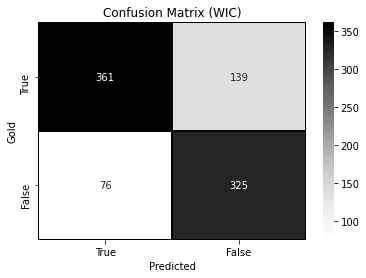

In [23]:
# ----------- Print confusion matrix -------------
ax = plt.subplot()
sns.heatmap(confusion_matrix(wic_gold, predictions_wic, labels=['True', 'False']), annot=True, ax=ax, cmap='Greys', fmt='d', linewidths=0.5, linecolor='black')
ax.set_title('Confusion Matrix (WIC)')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.set_xlabel('Predicted')
ax.yaxis.set_ticklabels(['True', 'False'])
_ = ax.set_ylabel('Gold')